In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

In [6]:
pwd

'/Users/jinbiao.ji/mygithub/MLTSA_JJi/midterm'

In [7]:
ls

COVID-19-models.ipynb     coronavirus-in-italy/     covid19-in-usa.zip
Covid-19-US.ipynb         coronavirus-in-italy.zip  covid19_data.csv
china-covid19-data/       coronavirusdataset/
china-covid19-data.zip    covid19-in-usa/


In [8]:
from fbprophet import Prophet, diagnostics
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, add_changepoints_to_plot, plot_plotly


In [9]:
time = pd.read_csv('coronavirusdataset/Time.csv')
time.tail()

,date,time,test,negative,confirmed,released,deceased
66,2020-03-26,0,364942,341332,9241,4144,131
67,2020-03-27,0,376961,352410,9332,4528,139
68,2020-03-28,0,387925,361883,9478,4811,144
69,2020-03-29,0,394141,369530,9583,5033,152
70,2020-03-30,0,395194,372002,9661,5228,158


In [10]:
time['date'] = pd.to_datetime(time['date'], format='%Y-%m-%d')

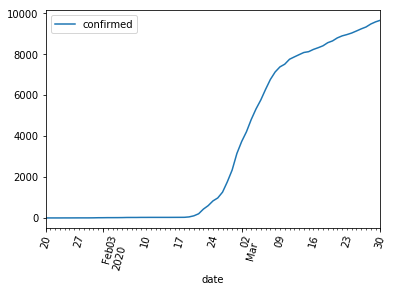

In [11]:
pd.plotting.register_matplotlib_converters()
time.plot(x='date',y='confirmed',rot = 75);

In [12]:
confirmed_data=time.reset_index().rename(columns={'date':'ds','confirmed':'y'})
confirmed_data.head()

,index,ds,time,test,negative,y,released,deceased
0,0,2020-01-20,16,1,0,1,0,0
1,1,2020-01-21,16,1,0,1,0,0
2,2,2020-01-22,16,4,3,1,0,0
3,3,2020-01-23,16,22,21,1,0,0
4,4,2020-01-24,16,27,25,2,0,0


In [13]:
confirmed_data.y[50]

7513

### Daily increase

In [14]:
dailyIncrease = [0]
for i in range(confirmed_data.y.size-1):
    dailyIncrease.append(confirmed_data.y[i+1]- confirmed_data.y[i])

In [15]:
confirmed_data['dailyIncrease'] = np.array(dailyIncrease)

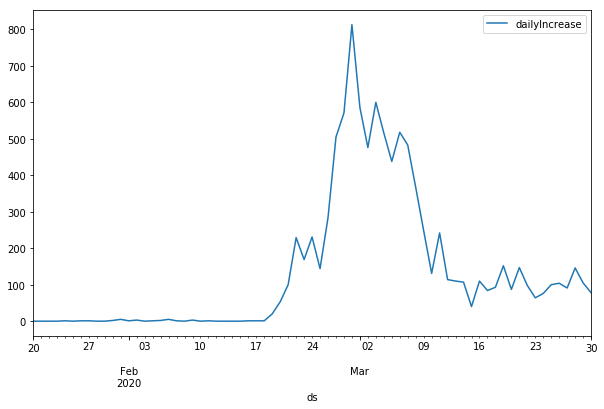

In [16]:
fig,ax=plt.subplots(figsize=(10,6))
confirmed_data.plot(x='ds',y='dailyIncrease',ax=ax)

In [17]:
def mape(y, ytrue): #mean absolute percentage error
    return np.mean(np.abs((ytrue-y)/ytrue))

### 1. Using the default settings to make the prediction.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


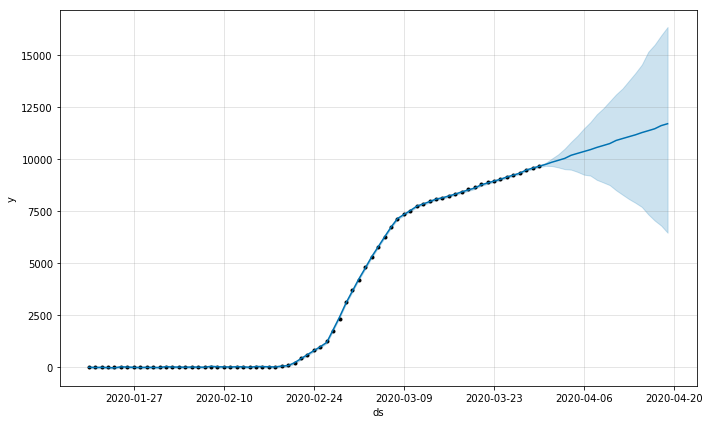

In [18]:
m=Prophet(changepoint_prior_scale=0.5,interval_width=0.95)


m.fit(confirmed_data)

future = m.make_future_dataframe(periods=20)
forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)

#a1 = add_changepoints_to_plot(fig1.gca(), m, forecast)

# 2. Using linear growth with only weekly seasonality and define the changepoints.

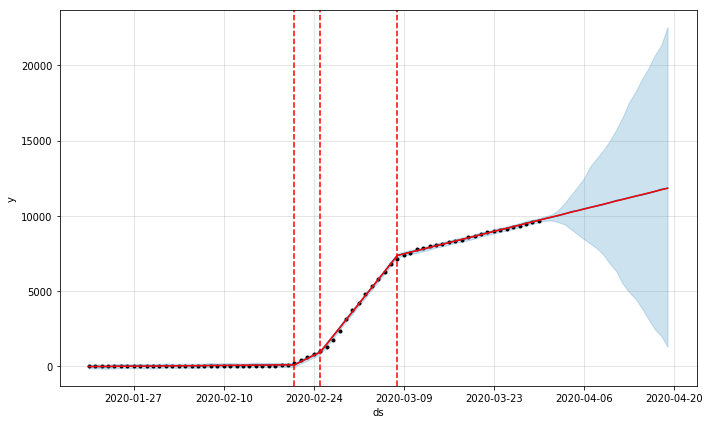

In [98]:
simp = Prophet(growth='linear',interval_width=0.95,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints = ['2020-02-21', '2020-02-25','2020-03-08'],
    changepoint_prior_scale=0.1)
#confirmed_data['cap'] = 10000
simp.fit(confirmed_data)
future = simp.make_future_dataframe(periods=20)
forecast = simp.predict(future)
fig3 = simp.plot(forecast)

a3 = add_changepoints_to_plot(fig3.gca(), simp, forecast)


In [120]:
cvresult_simp = cross_validation(simp, horizon = '10 days')

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00


In [21]:
cvresult_simp.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-20,38.171636,31.152340,44.829907,104,2020-02-19
1,2020-02-21,39.921626,32.853633,46.692185,204,2020-02-19
2,2020-02-22,40.171633,33.341304,47.033225,433,2020-02-19
3,2020-02-23,42.171620,35.416860,48.560665,602,2020-02-19
4,2020-02-24,43.805952,37.412944,50.437315,833,2020-02-19


In [22]:
print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simp.yhat, 
                                                           cvresult_simp.y)))

Mean absolute percentage error is  0.4214.


In [23]:
performance_metrics(cvresult_simp)

,horizon,mse,rmse,mae,mape,coverage
0,1 days,1.270273e+06,1127.063887,604.615322,0.321759,0.428571
1,2 days,1.659995e+06,1288.407796,750.607289,0.357436,0.285714
2,3 days,2.479590e+06,1574.671326,1001.520377,0.389843,0.285714
3,4 days,3.406510e+06,1845.673400,1243.042170,0.406889,0.428571
4,5 days,4.592817e+06,2143.085817,1533.319135,0.423473,0.428571
5,6 days,5.820301e+06,2412.530006,1754.000728,0.432099,0.571429
6,7 days,7.056244e+06,2656.359144,1989.349270,0.441815,0.571429
7,8 days,9.620389e+06,3101.675156,2371.193148,0.468991,0.428571
8,9 days,1.124463e+07,3353.301668,2633.470829,0.478736,0.428571
9,10 days,1.324788e+07,3639.763108,2938.241060,0.492592,0.428571


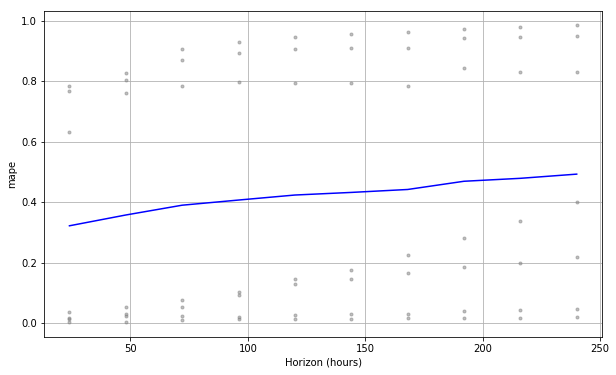

In [24]:
plot_cross_validation_metric(cvresult_simp, metric='mape');

# 3. Logistic growth with only daily seasonality.

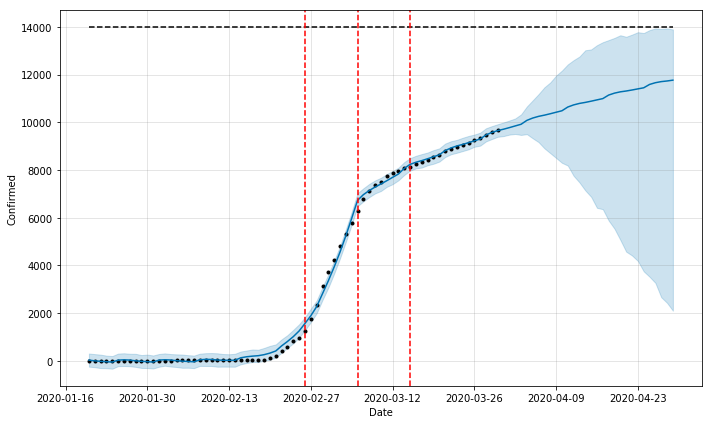

In [99]:
simlog1 = Prophet(growth='logistic',interval_width=0.95,n_changepoints=6,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoint_prior_scale=0.5)
confirmed_data['cap'] = 14000
simlog1.fit(confirmed_data)
future = simlog1.make_future_dataframe(periods=30)
future['cap'] = 14000
forecast = simlog1.predict(future)

fig4, ax = plt.subplots(figsize=(10,6))
simlog1.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')

a = add_changepoints_to_plot(fig4.gca(), simlog1, forecast,trend = False)


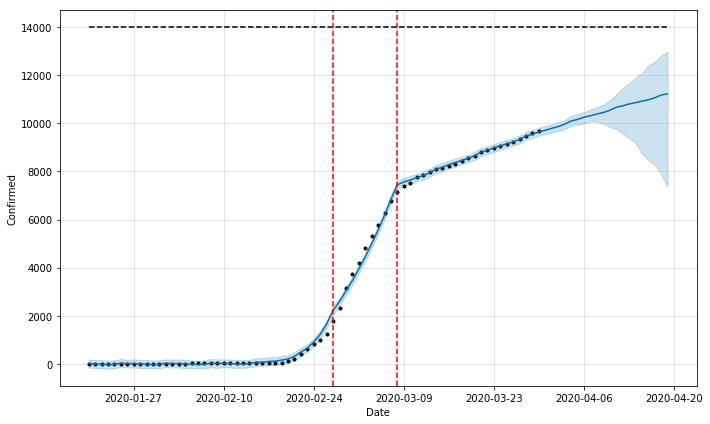

In [64]:
#define changepoints
simlog2 = Prophet(growth='logistic',
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints = ['2020-02-27','2020-03-08'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=1)
confirmed_data['cap'] = 14000
simlog2.fit(confirmed_data)
future = simlog2.make_future_dataframe(periods=20)
future['cap'] = 14000
forecast = simlog2.predict(future)

fig5, ax = plt.subplots(figsize=(10,6))
simlog2.plot(forecast,ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Confirmed')

a5 = add_changepoints_to_plot(fig5.gca(), simlog2, forecast,trend=False)


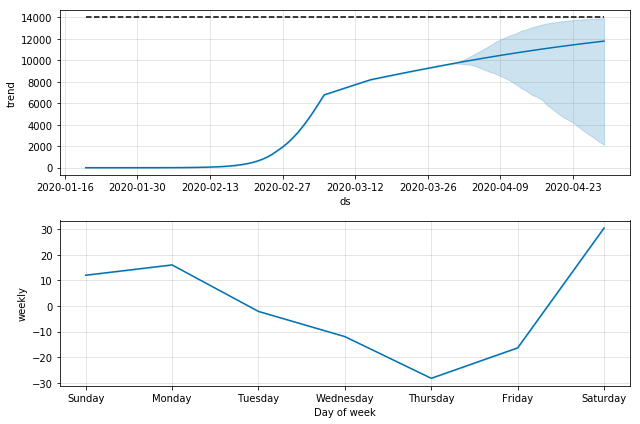

In [101]:
#future = simlog1.make_future_dataframe(periods=30)
#future['cap'] = 11000
#forecast = simlog1.predict(future)
simlog2.plot_components(forecast);

In [103]:
cvresult_simlog1 = cross_validation(simlog1, horizon = '10 days')

print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlog1.yhat, 
                                                           cvresult_simlog1.y)))
performance_metrics(cvresult_simlog1)

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00


Mean absolute percentage error is  0.4231.


,horizon,mse,rmse,mae,mape,coverage
0,1 days,3.568484e+05,597.367916,477.147684,0.198113,0.142857
1,2 days,7.853603e+05,886.205574,757.326862,0.286372,0.142857
2,3 days,1.456914e+06,1207.026990,1064.053613,0.339031,0.142857
3,4 days,2.541273e+06,1594.137091,1408.023222,0.387224,0.142857
4,5 days,4.084887e+06,2021.110424,1783.552540,0.423686,0.142857
5,6 days,5.833299e+06,2415.222394,2117.736149,0.461913,0.142857
6,7 days,8.122303e+06,2849.965369,2479.117433,0.501019,0.142857
7,8 days,1.074691e+07,3278.247874,2864.605688,0.528316,0.142857
8,9 days,1.316258e+07,3628.027010,3179.771045,0.545051,0.285714
9,10 days,1.567053e+07,3958.601682,3499.943416,0.560038,0.285714


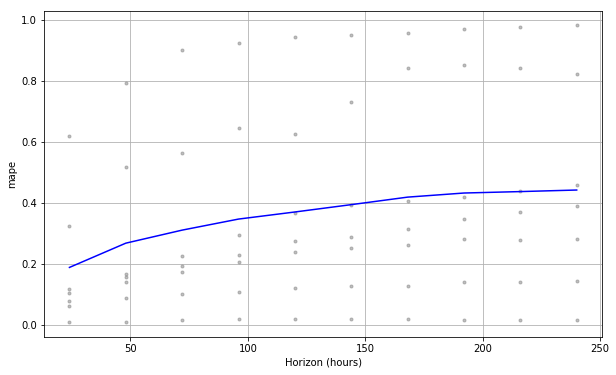

In [308]:
plot_cross_validation_metric(cvresult_simlog1, metric='mape');

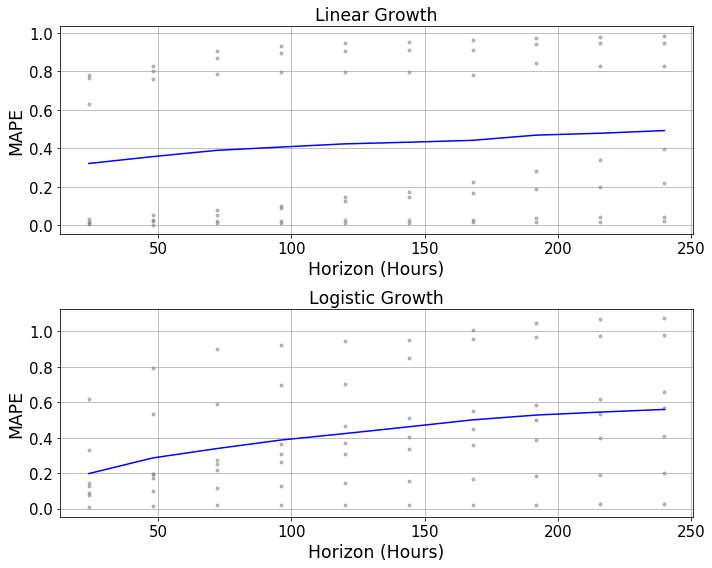

In [121]:
figcv, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))

#linear
plot_cross_validation_metric(cvresult_simp, metric='mape',ax=ax1);
ax1.set_title('Linear Growth',fontsize='xx-large' )
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel('Horizon (Hours)',fontsize='xx-large')
ax1.set_ylabel('MAPE',fontsize='xx-large')

#logistic
plot_cross_validation_metric(cvresult_simlog1, metric='mape',ax=ax2);
ax2.set_title('Logistic Growth',fontsize='xx-large')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel('Horizon (Hours)',fontsize='xx-large')
ax2.set_ylabel('MAPE',fontsize='xx-large')

figcv.tight_layout();

**Figure.** Horizon is the number of days in the future we care about forecasting. Dots show the absolute percent error for each prediction in confirmed cases. The blue line shows the MAPE (Mean Absolute Percentage Error), where the mean is taken over a rolling window of the dots. 
We see for the linear model forecast that errors are around 32% for 1 day into the future and then increas up to around 50% for predictions that are 10 days out. For the logistic model forecast, errors are around 19% for 1 day into the future and then increas up to around 44% for predictions that are 10 days out.

In [76]:
figvs.gca()

In [78]:
ax1

In [79]:
ax2

### Plot linear vs logistic models.

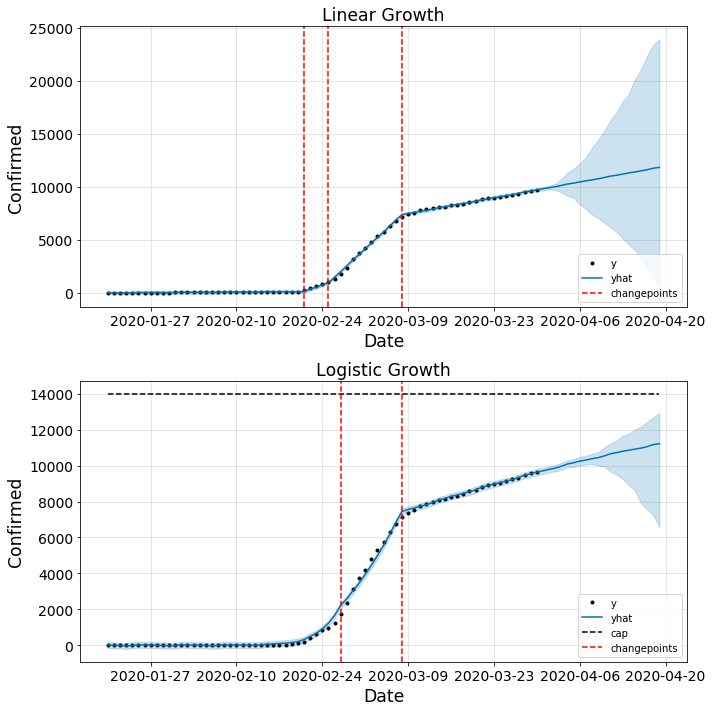

In [118]:
figvs, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))

#linear
future = simp.make_future_dataframe(periods=20)
forecast = simp.predict(future)
fig1 =simp.plot(forecast,ax = ax1);
ax1.set_title('Linear Growth',fontsize='xx-large' )
ax1.set_xlabel('Date',fontsize='xx-large')
ax1.set_ylabel('Confirmed',fontsize='xx-large')
ax1.tick_params(axis='both', which='major', labelsize=14)
#ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60)

a1=add_changepoints_to_plot(ax=ax1,m=simp, fcst=forecast,trend = False)
a1[0].set_label('changepoints')
ax1.legend(loc=4)

#logistic
future = simlog2.make_future_dataframe(periods=20)
future['cap'] = 14000
forecast = simlog2.predict(future)
figvs2=simlog2.plot(forecast,ax=ax2)
ax2.set_xlabel('Date',fontsize='xx-large')
ax2.set_ylabel('Confirmed',fontsize='xx-large')
ax2.set_title('Logistic Growth',fontsize='xx-large')
a2 = add_changepoints_to_plot(ax=ax2, m=simlog2, fcst=forecast,trend = False)

ax2.tick_params(axis='both', which='major', labelsize=14)

#ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60)
a2[0].set_label('changepoints')
ax2.legend(loc=4)

figvs.tight_layout()


#### Define changepoints

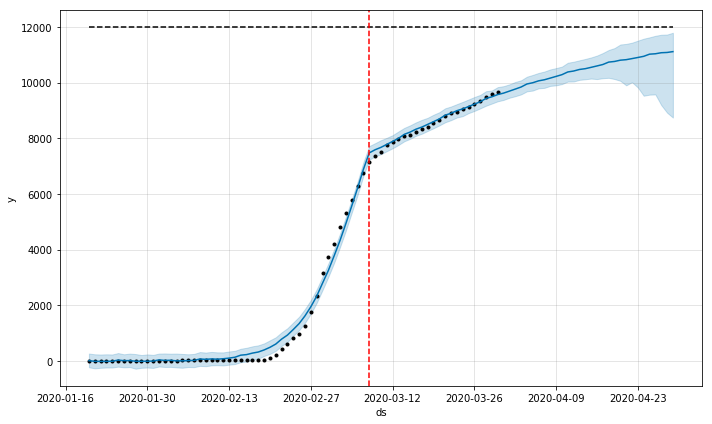

In [38]:
#define changepoints
simlog2 = Prophet(growth='logistic',
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoints = ['2020-03-08'],  #'2020-02-21', '2020-02-27',
    changepoint_prior_scale=0.5)
confirmed_data['cap'] = 12000
simlog2.fit(confirmed_data)
future = simlog2.make_future_dataframe(periods=30)
future['cap'] = 12000
forecast = simlog2.predict(future)
fig5 = simlog2.plot(forecast)

a5 = add_changepoints_to_plot(fig5.gca(), simlog2, forecast,trend=False)

In [338]:
cvresult_simlog1 = cross_validation(simlog2, horizon = '10 days')

print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlog2.yhat, 
                                                           cvresult_simlog2.y)))
performance_metrics(cvresult_simlog2)

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00


Mean absolute percentage error is  0.3020.


,horizon,mse,rmse,mae,mape,coverage
0,1 days,2.005167e+05,447.790865,345.704342,0.396255,0.285714
1,2 days,4.062043e+05,637.341565,509.591484,0.231309,0.285714
2,3 days,7.028082e+05,838.336589,664.012340,0.190300,0.285714
3,4 days,1.193016e+06,1092.252599,872.434556,0.244945,0.285714
4,5 days,1.839014e+06,1356.102339,1101.149859,0.278177,0.285714
5,6 days,2.550177e+06,1596.927347,1285.552255,0.302766,0.285714
6,7 days,3.448705e+06,1857.068878,1491.147811,0.330851,0.285714
7,8 days,4.210825e+06,2052.029370,1673.442967,0.343557,0.285714
8,9 days,4.902112e+06,2214.071445,1824.000545,0.348355,0.285714
9,10 days,5.788328e+06,2405.894508,2003.393605,0.353576,0.285714


In [143]:
cvresult_simlog2 = cross_validation(simlog2, horizon = '10 days')

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00


In [144]:
print('Mean absolute percentage error is  {:.4f}.'.format(mape(cvresult_simlog2.yhat, 
                                                           cvresult_simlog2.y)))

Mean absolute percentage error is  0.3020.


### MCMC optimization

This parameter determines if the model uses Maximum a posteriori (MAP) estimation or a full Bayesian inference with the specified number of Markov Chain Monte Carlo (MCMC) samples to train and predict.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



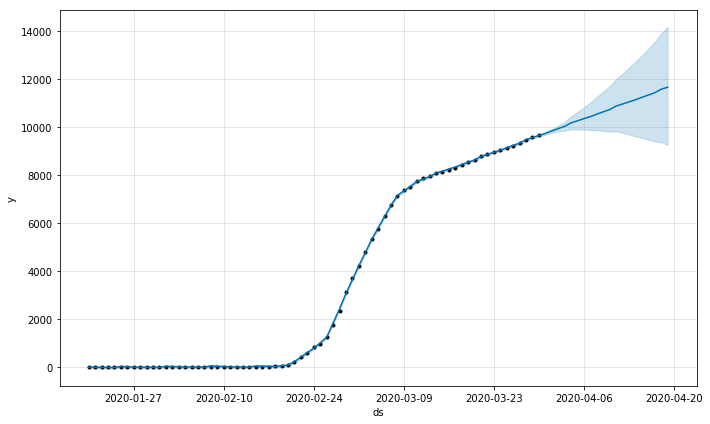

In [21]:
regmcmc = Prophet(mcmc_samples=5000)

#regmcmc.add_country_holidays(country_name='KR')

#confirmed_data['cap'] = 11000
regmcmc.fit(confirmed_data)
future = regmcmc.make_future_dataframe(periods=20)
#future['cap'] = 11000
forecast = regmcmc.predict(future)
fig7 = regmcmc.plot(forecast)

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



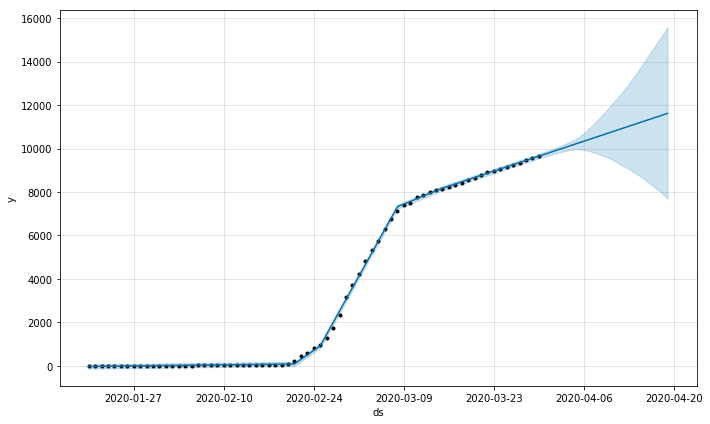

In [24]:
regmcmc2 = Prophet( yearly_seasonality=False,
    weekly_seasonality = False,
    daily_seasonality = True,
    seasonality_mode = 'additive',
    changepoints = ['2020-02-21', '2020-02-25','2020-03-08','2020-03-15'],
    changepoint_prior_scale=0.5,
                   mcmc_samples=5000)

#regmcmc.add_country_holidays(country_name='KR')

#confirmed_data['cap'] = 11000
regmcmc2.fit(confirmed_data)
future = regmcmc2.make_future_dataframe(periods=20)
#future['cap'] = 11000
forecast = regmcmc2.predict(future)
fig8 = regmcmc2.plot(forecast)

In [53]:
cvresult_regmcmc = diagnostics.cross_validation(regmcmc, horizon = '10 days')


INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-02-19 00:00:00 and 2020-03-20 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/jinbiao.ji/anaconda3/lib/python3.7/site-package

In [127]:
cvresult_regmcmc.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
65,2020-03-26,11599.675486,10608.485318,12550.321210,9241,2020-03-20
66,2020-03-27,11907.558972,10915.013556,12911.091570,9332,2020-03-20
67,2020-03-28,12395.158733,11374.112722,13411.752065,9478,2020-03-20
68,2020-03-29,12694.160522,11661.985074,13715.646528,9583,2020-03-20
69,2020-03-30,12988.444509,11913.713371,14041.460911,9661,2020-03-20


In [59]:
cvresult_regmcmc.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-20,38.395880,31.768425,45.026233,104,2020-02-19
1,2020-02-21,40.176921,33.553059,46.633744,204,2020-02-19
2,2020-02-22,40.427537,33.774595,47.107260,433,2020-02-19
3,2020-02-23,42.464411,35.672569,49.366382,602,2020-02-19
4,2020-02-24,43.891219,36.921213,50.631146,833,2020-02-19


In [128]:
performance_metrics(regmcmc)

AttributeError: 'Prophet' object has no attribute 'copy'

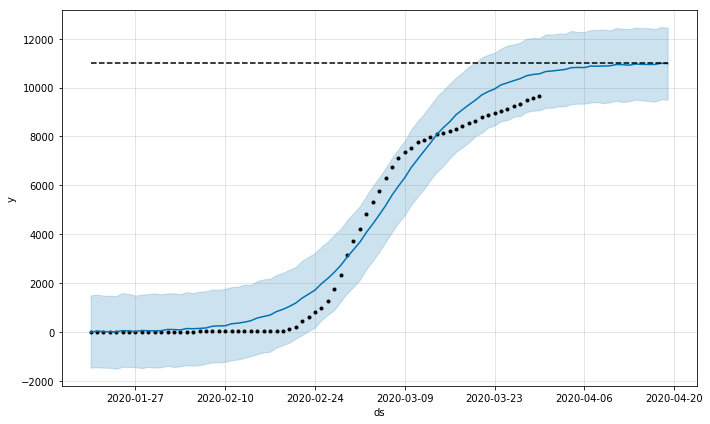

In [343]:
regmcmc3 = Prophet(growth='logistic',interval_width=0.95,
    yearly_seasonality=False,
    weekly_seasonality = True,
    daily_seasonality = False,
    changepoint_prior_scale=0.05,
    mcmc_samples=5000)

#regmcmc.add_country_holidays(country_name='KR')

confirmed_data['cap'] = 11000
regmcmc3.fit(confirmed_data)
future = regmcmc3.make_future_dataframe(periods=20)
future['cap'] = 11000
forecast = regmcmc3.predict(future)
fig9 = regmcmc3.plot(forecast)

In [341]:
#cvresult_regmcmc3 = diagnostics.cross_validation(regmcmc3, horizon = '10 days')

### Logistics Growth - Define funcion with the coefficients to estimate the 'cap'.

In [74]:
def func_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

In [77]:
from scipy.optimize import curve_fit

In [102]:
# Randomly initialize the coefficients
p0 = np.random.exponential(size=3)

# Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
bounds = (0, [100000., 1000., 1000000000.])

# Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
x = np.array(time.index.values)+1
y = np.array(time['confirmed'])

(a,b,c),cov = curve_fit(func_logistic, 
                              x, y, bounds=bounds, p0=p0, maxfev=1000000)

In [104]:
# The time step at which the growth is fastest
t_fastest = np.log(a) / b
i_fastest = func_logistic(t_fastest, a, b, c)

In [115]:
res_df = time['date'].copy()
res_df['fastest_grow_day'] = t_fastest
res_df['fastest_grow_value'] = i_fastest
res_df['growth_stabilized'] = t_fastest <= x[-1]
res_df['timestep'] = x
res_df['res_func_logistic'] = func_logistic(x, a, b, c)


if t_fastest <= x[-1]:
    print('Growth stabilized: South Korea.','| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
    res_df['cap'] = func_logistic(x[-1] + 10, a, b, c)
else:
    print('Growth increasing: South Korea,',  '| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
    res_df['cap'] = func_logistic(i_fastest + 10, a, b, c)

Growth stabilized: South Korea. | Fastest grow day: 43.89792405460557 | Infections: 4477.29619478658


In [342]:
print('Estimated cap is ',res_df['cap'])

Estimated cap is  8954.002674075082


### Step 2

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jinbiao.ji/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



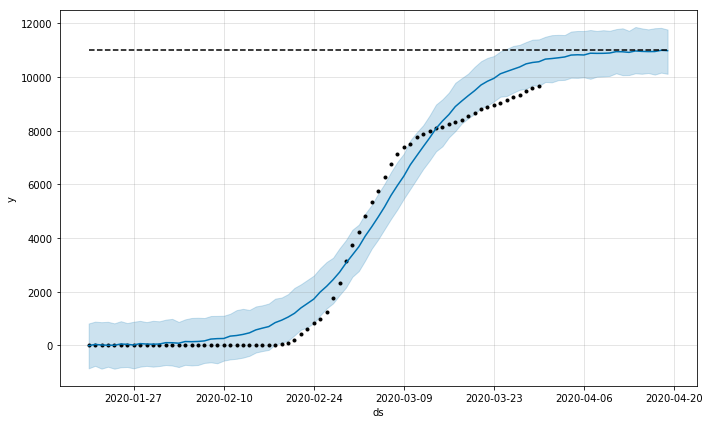

In [120]:
m = Prophet(growth='logistic')
m.fit(confirmed_data)
future = m.make_future_dataframe(periods=20)
future['cap'] = 11000
forecast = m.predict(future)
fig5 = simlog2.plot(forecast)